# Trabajo Final: Ejercicio 1

Este ejercicio consiste en trabajar sobre la primera parte del curso para extraer un modelo geométrico de una imagen.

Para este ejercicio vamos a trabajar sobre una imagen de una cancha de Fútbol.

Se probeen las funciones `draw_lines` y `draw_lines_polar` que les pueden servir para dibujar las rectas encontradas. 

\**En los ejercicios del trabajo final es posible utilizar funciones de librerias existentes o código sacado de internet. Siempre y cuando **no se usen para resolver explicitamente lo que pide el ejercicio** y al código sacado de internet le agreguen el link en comentarios de donde fue sacado ese código.*

## Imports y carga de datos

In [1]:
import cv2
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from image_utils import draw_lines, draw_lines_polar, draw_points

from operator import itemgetter
import math

import pickle
import itertools
import math

### Load Input Image ###

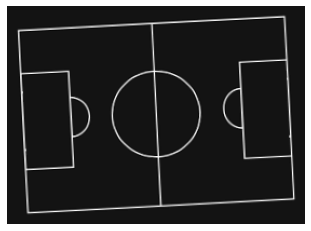

In [2]:

input_image = 'images/football.png'
image = cv2.imread(input_image,cv2.IMREAD_GRAYSCALE)/255

plt.imshow(image,cmap='gray')
plt.axis('off')
plt.show()

In [3]:
image_bgr = cv2.imread(input_image,cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

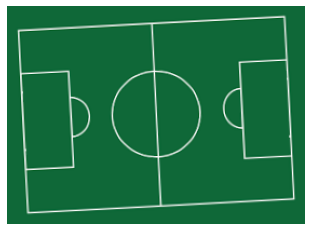

In [4]:
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

### Veamos como debería figurar nuestro detector de rectas

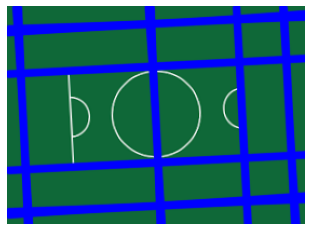

In [5]:
edges = cv2.Canny(image_rgb,100,200)

lines = cv2.HoughLines(edges, 1, np.pi / 180, 80, None, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(image_rgb, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
        

plt.imshow(image_rgb)
plt.axis('off')
plt.show()

# reloadeamos la imagen para que no aparezcan las líneas azules a posteriori
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

### Preparamos la imagen para poder hallar sus líneas

In [6]:
blurred = cv2.GaussianBlur(image_bgr,(5,5),0)
blurred_grey = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

(Text(0.5, 1.0, 'Edge Image'), ([], []), ([], []))

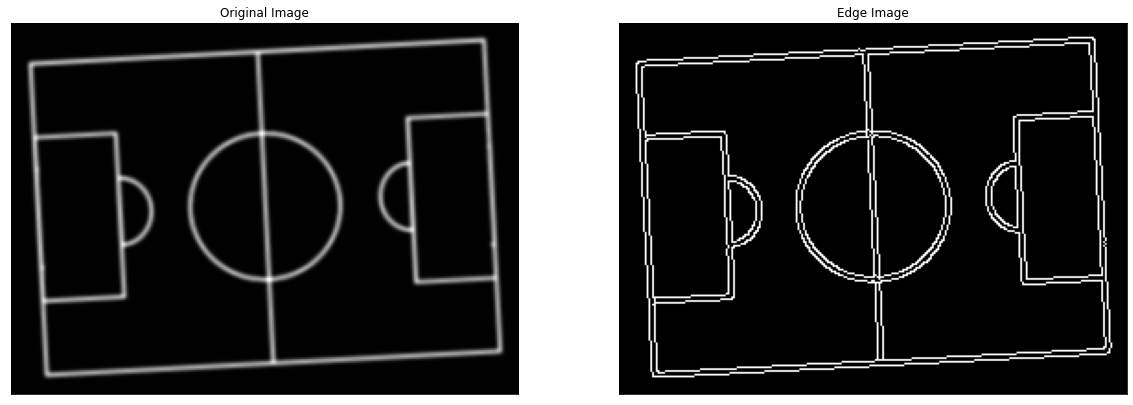

In [7]:
img = blurred_grey
edges = cv2.Canny(img,100,200)


figure(figsize=(20, 10))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

## Primer intento (¡no correr!)

## Hough Transform

1. armamos grilla de (rho, theta)
1. para cada rt = (rho, theta), calculamos distancia de blancos a recta rt, y ese punto pertenece si d < threshold
1. guardamos en cada posicion de la grilla la cantidad de puntos para la recta rt
1. elegimos máximos de puntos con rho, theta lo suficientemente distintos. Es decir, agarramos un máximo, y si agarramos otro máximo con rho, theta similar, lo descartamos y seguimos iterando por la lista de máximos

In [8]:
%%script false --no-raise-error
def polar_line_to_px(image, rho, theta, is_theta_grad=False):
    if is_theta_grad:
        theta = np.deg2rad(theta)
    phis = np.arange(-np.pi,np.pi,0.01)
    xs = np.array([ (rho/np.cos(phi-theta))*np.cos(phi) for phi in phis])
    ys = np.array([ (rho/np.cos(phi-theta))*np.sin(phi) for phi in phis])
    xs_in_image = (xs>0) & (xs < image.shape[1])
    ys_in_image = (ys>0) & (ys < image.shape[0])
    filter = xs_in_image & ys_in_image
    xs = xs[filter]
    ys = ys[filter]
    return xs, ys

In [9]:
%%script false --no-raise-error
def distance_point_to_point_defined_line(point, line):
#     https://stackoverflow.com/questions/39840030/distance-between-point-and-a-line-from-two-points
    p1 = np.asarray(line[0])
    p2 = np.asarray(line[-1])
    p3 = np.asarray(point)
    return np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)

#     muy lento, vamos con otro camino


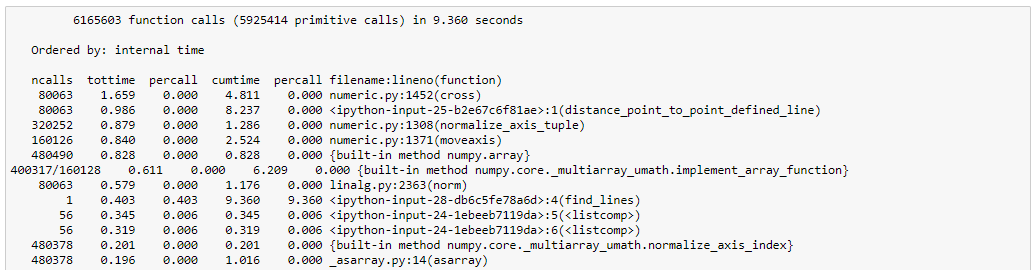

In [10]:
%%script false --no-raise-error
def distance_point_to_point_defined_line(point, line):
    # https://stackoverflow.com/questions/1988091/poor-numpy-cross-performance
    # https://stackoverflow.com/questions/40970478/python-3-5-2-distance-from-a-point-to-a-line
    p1 = line[0]
    p2 = line[-1]
    x_diff = p2[0] - p1[0]
    y_diff = p2[1] - p1[1]
    num = abs(y_diff*point[0] - x_diff*point[1] + p2[0]*p1[1] - p2[1]*p1[0])
    den = math.sqrt(y_diff**2 + x_diff**2)
    return num / den

In [11]:
%%script false --no-raise-error
def line_in_bucket(line_parameters, buckets, rho_threshold, theta_threshold):
    ''' buckets es un diccionario de diccionarios, con primera clave rho, segunda clave theta, valor True/False'''
    rho, theta = line_parameters
    rounded_rho = rho - rho%rho_threshold
    rounded_theta = theta - theta%theta_threshold
    
    rho_bucket = buckets.get(rounded_rho)
    if rho_bucket is not None:
        line_already_added = rho_bucket.get(rounded_theta)
        if line_already_added is not None:
            return line_already_added
        else:
            rho_bucket[rounded_theta] = True
            return False
    else:
        new_bucket = {}
        buckets[rounded_rho] = new_bucket
        new_bucket[rounded_theta] = True
        return False
        

In [12]:
%%script false --no-raise-error
def find_lines(img, line_amount, rho=None, theta=360, rho_thres_step=(5,1), theta_thres_step=(5,1), distance_threshold=2):

#     # flippeamos imagen para usar mismo origen de coordenadas
#     img = img[::-1,:]
    width, height = img.shape
    max_rho = math.ceil(math.sqrt(width**2 + height**2)) if rho is None else rho
    
    '''armamos grilla de (rho, thetha)'''
    parameters =  [ [rho_param, theta_param] \
                   for rho_param in np.arange(0,max_rho+1, rho_thres_step[1]) \
                   for theta_param in np.arange(0,theta+1, theta_thres_step[1]) ]
    
    inliers = np.zeros(len(parameters))
   
    white_pixels_index = np.nonzero(img == 255) # agarramos y y x de pixeles blancos (ordenado por y)
    white_pixels_index = white_pixels_index[::-1] # reordenamos a x e y
    white_pixels_index = sorted(white_pixels_index ,key=itemgetter(0)) # ordenamos por x
    white_pixels_index = list(zip(* white_pixels_index )) # zippeamos en lista de puntos
    
    '''para cada rt = (rho, theta), calculamos distancia de blancos a recta rt, y ese punto pertenece si d < threshold'''
    for it, (rho_it, theta_it) in enumerate(parameters):
        
        x, y = polar_line_to_px(img, rho_it, theta_it, is_theta_grad=True)
        line = list( zip( x, y ) )
        
        if not line: # si lista está vacía
            continue
        
        
        for row, column in white_pixels_index:
            '''para cada rt = (rho, theta), calculamos distancia de blancos a recta rt, y ese punto pertenece si d < threshold'''
            distance = abs(distance_point_to_point_defined_line(point, line))
            '''guardamos en cada posicion de la grilla la cantidad de puntos para la recta rt'''
            inliers[it] += 1 if distance < distance_threshold else 0
            
    indexes_of_lines_with_most_inliers_asc = np.argsort(inliers)
    indexes_of_lines_with_most_inliers_desc = indexes_of_lines_with_most_inliers_asc[::-1]
    
    '''elegimos máximos de puntos con rho, theta lo suficientemente distintos. 
        Es decir, agarramos un máximo, y si agarramos otro máximo con rho, theta similar, 
        lo descartamos y seguimos iterando por la lista de máximos'''
    
    # vamos agregando a una lista las mejores rectas
    # antes de agregarla, nos fijamos que una parecida no haya sido agregada antes
    # si sí, no la agregamos
    # para saber si una similar fue agregada, buscamos en buckets de ese rango
    
    buckets = {}
    lines = []
    for i in indexes_of_lines_with_most_inliers_desc:
        line_parameters = parameters[i]
        if not line_in_bucket(line_parameters, buckets, rho_thres_step[0], theta_thres_step[0]):
            lines.append(line_parameters)

#         if len(lines) > line_amount:
#             return lines

    return lines   

In [13]:
%%script false --no-raise-error
%prun lines = find_lines(edges, 4, rho_thres_step=(10,1), theta_thres_step=(10,1), distance_threshold=10)

Correr con numpy toma 18045s = 5h
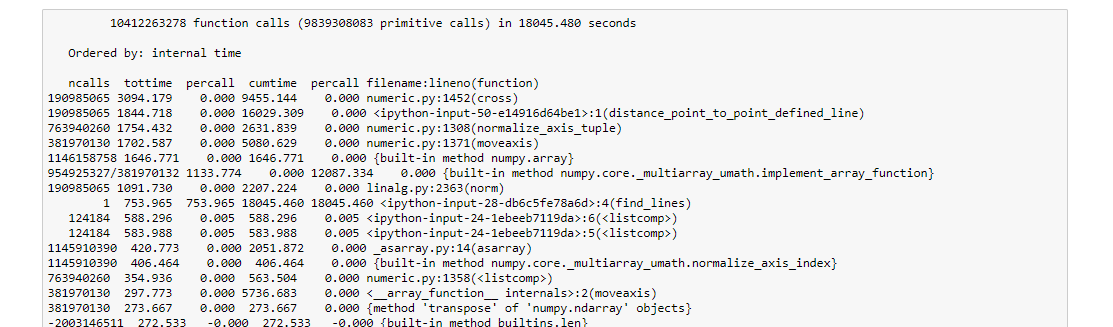

Correr von python pelado toma 3503s=1h
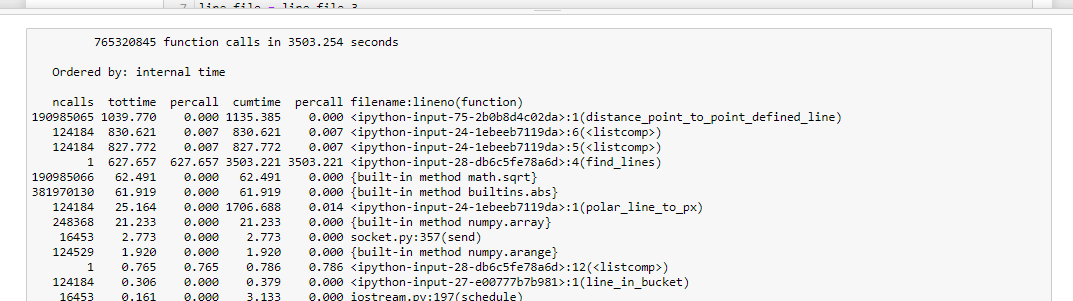

In [14]:
%%script false --no-raise-error
line_file = 'aaaa'

with open(line_file, 'wb') as f:
    pickle.dump(lines, f)

In [15]:
%%script false --no-raise-error
line_file = 'aaaa'

with open(line_file, 'rb') as f:
    lines = pickle.load(f)

In [16]:
%%script false --no-raise-error
# draw_lines_polar(image_rgb, lines[0:40], theta_grad=True)
draw_lines_polar(image_rgb, lines[0:20], theta_grad=True)

In [17]:
%%script false --no-raise-error
draw_lines_polar(image_rgb[::-1], lines[0:20], theta_grad=True)

## Hough Transform: segundo intento (¡sí correr!)

1. armamos grilla de (rho, theta). En realidad, armamos grilla de inliers para cada rho, theta
1. para cada punto blanco, hallamos las rectas que pasan por él, y les sumamos 1. Será más rápido porque ya no iteramos según rho y theta, sino sólo según theta: rho se saca con trigonometría de los catetos formados por theta.
1. agarramos los máximos de esa grilla que estén lo "suficientemente" alejados entre sí

Vamos a usar esta justificación, que nos permite para cada (pixel_x, pixel_y, theta) hallar el rho, que nos ahorra cálculos al solo tener que iterar por todos los theta para hallar las rectas que pasan por cada punto:
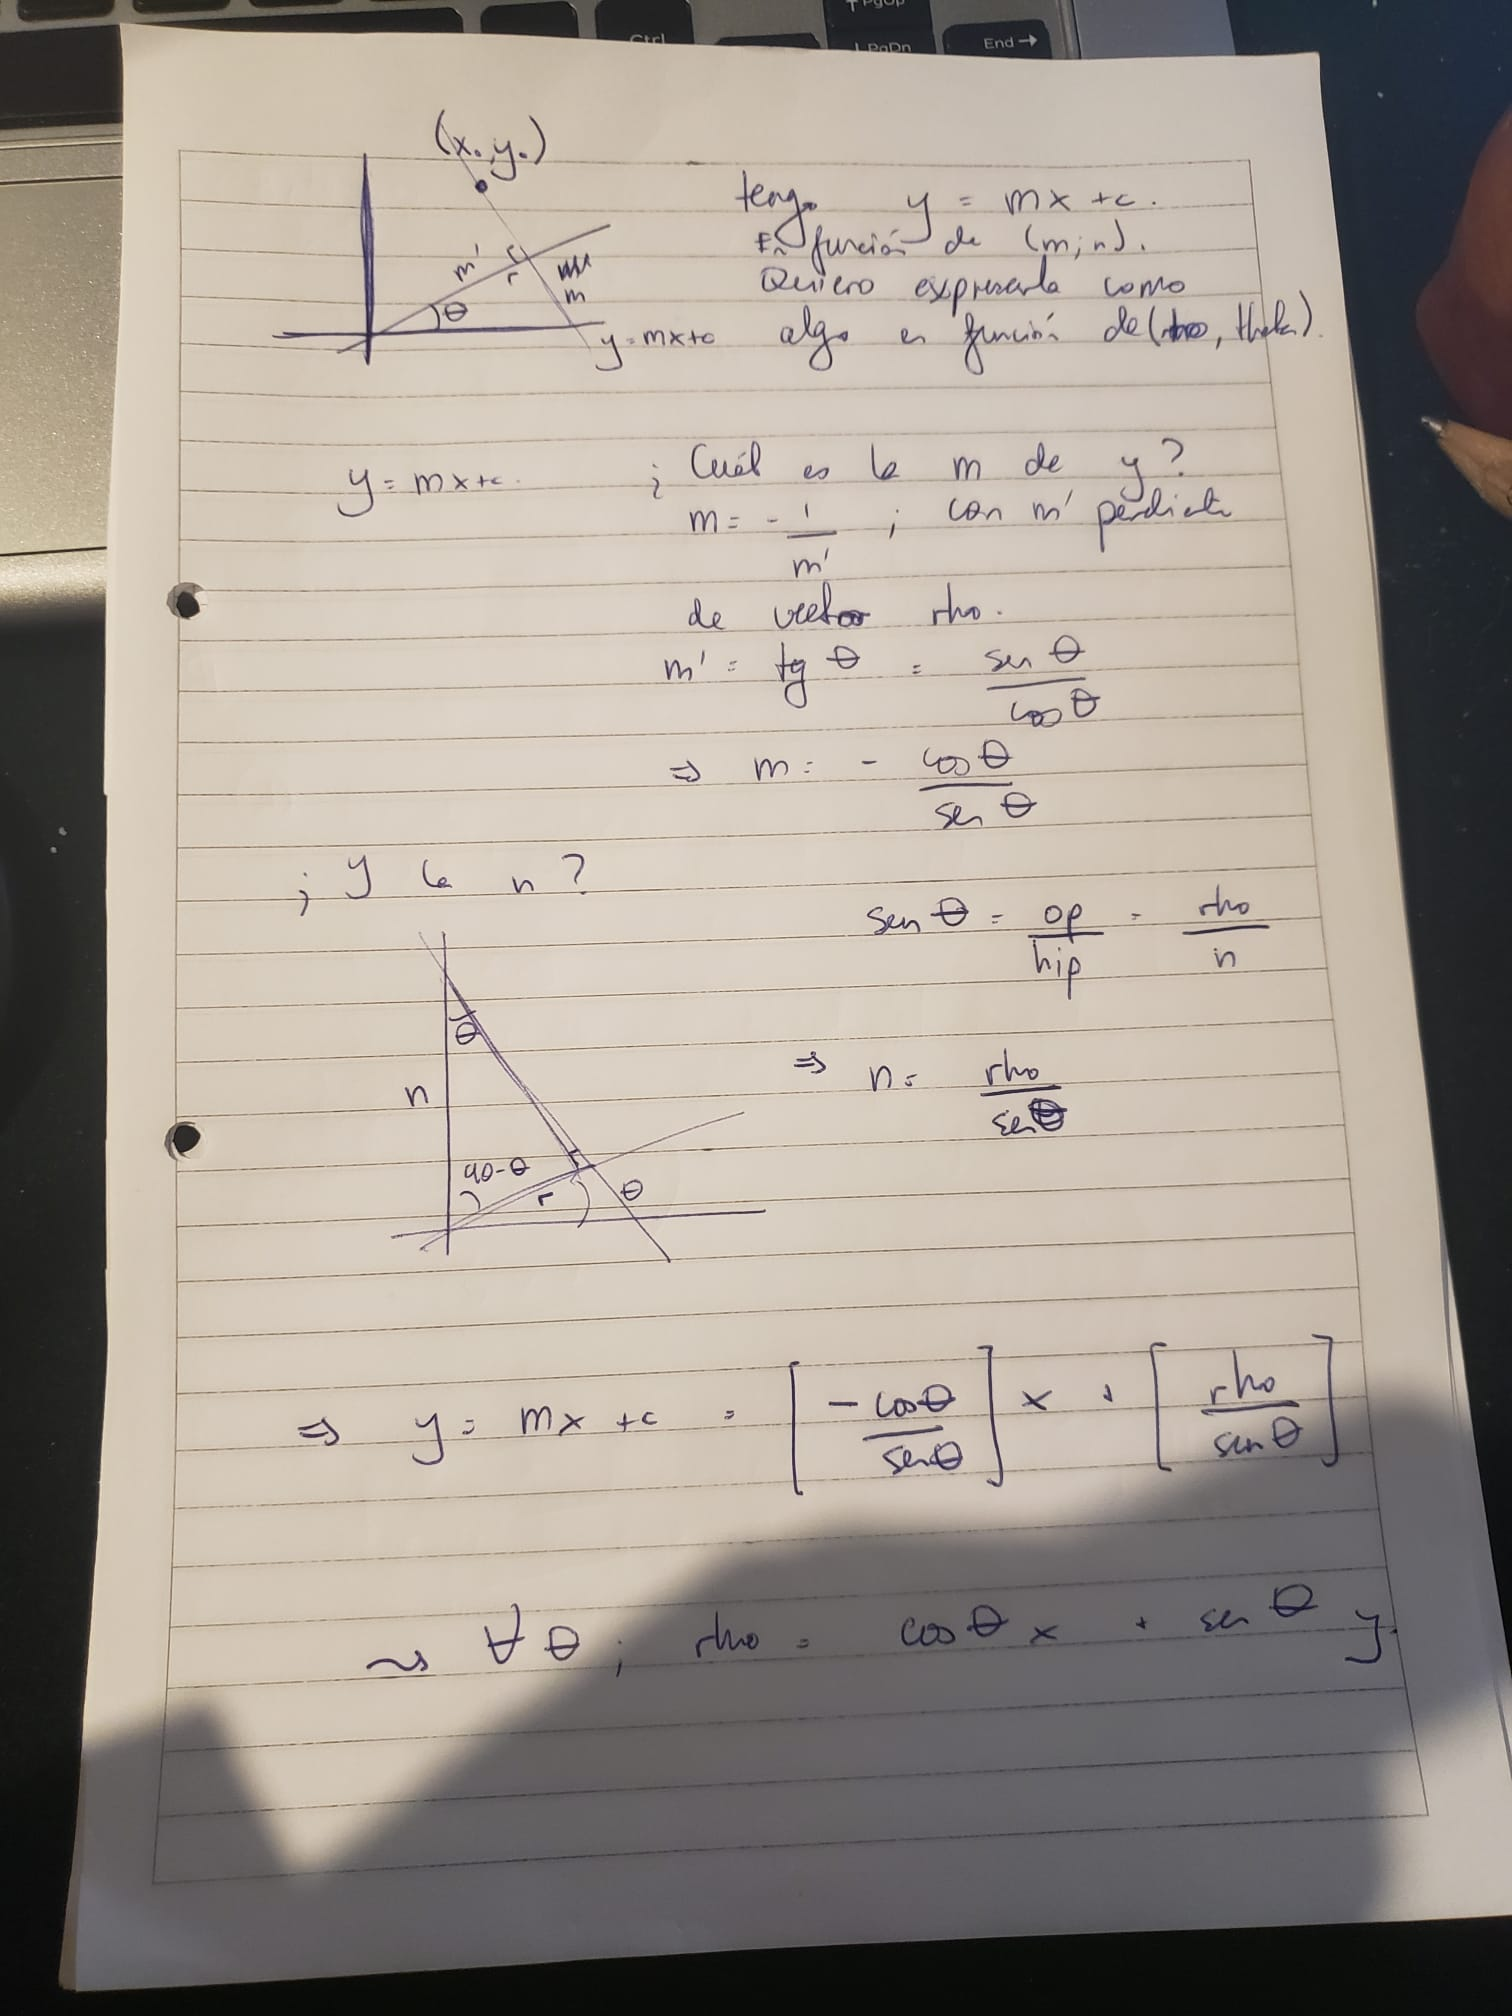

Además, podemos pre-computar los sen(theta) y cos(theta)

In [18]:
def reorder_YX_2_XY(YX):
    XY_unordered_separated = YX[::-1] # reordenamos a x e y
    XY_unordered = list(zip(* XY_unordered_separated )) # zippeamos en lista de puntos
    XY = sorted(XY_unordered ,key=itemgetter(0)) # ordenamos por x
    return XY


def join(YX):
    return list(zip(* YX ))


def find_maximums_YX(grid):
    # Extraído de https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
    # Indices of the sorted elements of a N-dimensional array:
    # También está en tu solución de uno de los prácticos

    maximum_indexes_YX_separated_desc = np.unravel_index(np.argsort(grid, axis=None)[::-1], grid.shape)
    maximum_indexes_YX = join(maximum_indexes_YX_separated_desc)
    return maximum_indexes_YX


def calculate_bucket_amount(total, threshold):
    full = total//threshold
    missing = total%threshold
    extra = 0 if missing == 0 else 1
    return int(full+extra)


def find_lines(img, line_amount, rho=None, theta_deg=180, theta_deg_step=1, rho_thres=5, theta_deg_thres=5):

    # flippeamos imagen para usar mismo origen de coordenadas
    img = img[::-1,:]

    height, width = img.shape
    max_rho = math.ceil(math.sqrt(width**2 + height**2)) if rho is None else rho
    
    '''armamos grilla de (rho, thetha). En realidad, armamos grilla de inliers para cada rho, theta'''
    rho_theta_grid =  np.zeros((max_rho+1, int(theta_deg/theta_deg_step)))
    
    # pre-calculamos sen theta y cos theta
    theta_step_amount = int(theta_deg//theta_deg_step) # cuantos thetas vamos a evaluar
    thetas_deg = np.linspace(0,theta_deg,theta_step_amount,endpoint=False)
    # antes fue:
    # thetas_deg = np.array([th for th in range(0, theta_deg+1, theta_deg_step)])
    
    thetas_rad = np.deg2rad(thetas_deg)
    sin_theta = np.sin(thetas_rad)
    cos_theta = np.cos(thetas_rad)
    
    '''para cada punto blanco, hallamos las rectas que pasan por él, y les sumamos 1.
        Será más rápido porque ya no iteramos según rho y theta, 
        sino sólo según theta: rho se saca con trigonometría de los catetos formados por theta.'''
     
    white_pixels_index = np.nonzero(img == 255) # agarramos y y x de pixeles blancos (ordenado por y)
    white_pixels_index = reorder_YX_2_XY(white_pixels_index)
    
    for i, (pixel_x, pixel_y) in enumerate(white_pixels_index):
        # iteramos según theta, y vamos hallando el rho correspondiente
        for idx in range(len(thetas_rad)):
            # rho = cos theta x + sen theta y
            rho = cos_theta[idx] * pixel_x + sin_theta[idx] * pixel_y
            rho = math.ceil(rho)
            '''hallamos las rectas que pasan por él, y les sumamos 1'''
            rho_theta_grid[rho, idx] += 1   
    
    plt.imshow(rho_theta_grid)
    plt.colorbar()
    plt.show()            
    
    '''agarramos los máximos de esa grilla que estén lo "suficientemente" alejados entre sí'''
    # eso se implementa agrupando en buckets de menor resolución
    
    # como fijarnos por pixel mismo tira cualquiera, vamos a agrupar en buckets de rho_thres*theta_deg_thres
    total_shape =  rho_theta_grid.shape
    rho_bucket_quantity = calculate_bucket_amount(max_rho, rho_thres)
    theta_deg_bucket_quantity = calculate_bucket_amount(theta_deg, theta_deg_thres)
    buckets =  np.zeros((rho_bucket_quantity, theta_deg_bucket_quantity))
    
    for i in range(rho_bucket_quantity):
        for j in range(theta_deg_bucket_quantity):
#             buckets[i, j] = np.sum( rho_theta_grid[ i*rho_thres:i*rho_thres+rho_thres, j*theta_deg_thres:j*theta_deg_thres+theta_deg_thres ] )
            buckets[i, j] = np.sum( rho_theta_grid[ i*rho_thres:(i+1)*rho_thres, int(j//theta_deg_step)*theta_deg_thres:(int(j//theta_deg_step)+1)*theta_deg_thres ] )
    
    plt.imshow(buckets)
    plt.colorbar()
    plt.show()
    
    # después de agrupar en buckets, agarramos los máximos y sacamos qué rectas representan
    max_indexes_buckets = find_maximums_YX(buckets)

    # vamos a agarrar el punto medio de la ventana como parámetro que representa a todo el bucket
    max_indexes_parameters = np.zeros((len(max_indexes_buckets), 2))
    for i, (bucketed_rho, bucketed_theta) in enumerate(max_indexes_buckets):
#         max_indexes_parameters[i] = [rho_thres*bucketed_rho + rho_thres/2, theta_deg_thres*bucketed_theta + theta_deg_thres/2]
        max_indexes_parameters[i] = [ rho_thres*(bucketed_rho + 0.5), theta_deg_thres*(bucketed_theta + 0.5) ]
    
    return max_indexes_parameters

    # no se porqué pero aparecen rectas que no pasan por la  imagen (180<theta<270)dists[(dists >= r) & (dists <= r+dr)]
#     print(max_indexes_parameters.shape)
#     mask_lower_half = max_indexes_parameters[:, 1] >= 180 
#     mask_leftmost_half = max_indexes_parameters[:, 1] <= 270 
#     mask = mask_lower_half & mask_leftmost_half
#     return max_indexes_parameters[~mask]  

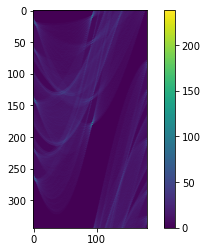

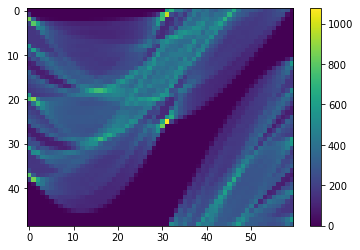

In [19]:
lines = find_lines(edges, 4, theta_deg_step=1, rho_thres=7, theta_deg_thres=3 )
# lines = find_lines(edges, 4, theta_deg_step=2, rho_thres=7, theta_deg_thres=3 )

### Mostramos las primeras 5 porque sabemos, luego de tunear, que esas 5 son las que queremos. 

#### Si, por ejemplo,agregamos resolución al theta para achatar los laterales de la cancha, ya no son las primeras 5, sino que se detectan otras líneas, y tenemos que mostrar más de 5.

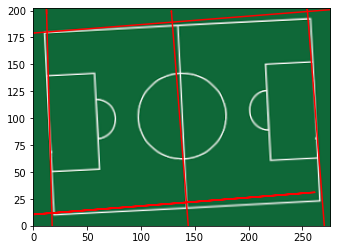

In [20]:
draw_lines_polar(image_rgb, lines[:5], theta_grad=True)

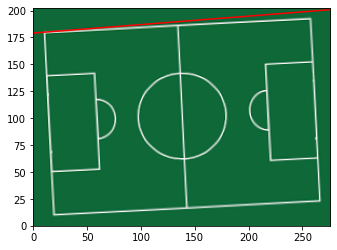

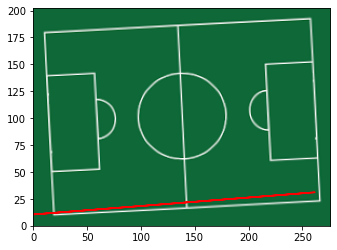

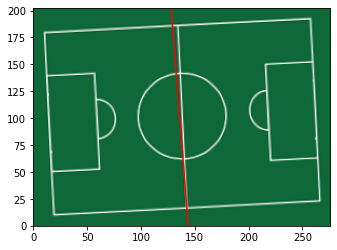

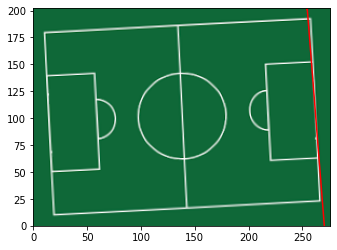

In [21]:
for i in range(4):
    draw_lines_polar(image_rgb, lines[i:i+1], theta_grad=True)

### Graficamos la intersección de las rectas para hallar las coordenadas de las esquinas

Algo que se podría haber hecho, tal vez, es tener mayor resolución en theta, mostrar más rectas (por lo que podrían haber 2 o 3 rectas por línea, pareciéndose a una "estrellita" o "pelos de gato").

Luego, hallar los puntos de intersección de todas esas rectas. Quedarían varios puntos cerca de cada esquina.

Luego, clusterizar en 6 clusters, y tomar esos 6 centroides como las coordenadas de 

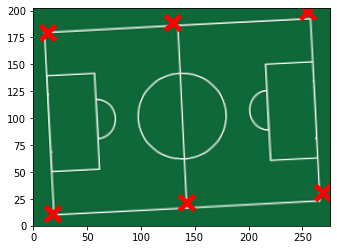

In [22]:
def find_intersection(*lines):
    # pasar de rho, theta a x.cost + y.sent = rho -> ax + by = r
#     a1, b1, r1 = cos(line[1]), sen(line[1]), line[0]
#     a1, b1, r1 = cos(line[1]), sen(line[1]), line[0]

    abr = np.zeros((len(lines), 3))
    for i, line in enumerate(lines):
        rho, theta_deg = line
        theta = math.radians(theta_deg)
        abr[i] = [ math.cos(theta), math.sin(theta), rho ]
        
    ab, r = abr[:,:2], abr[:,2]
    solution = linalg.solve(ab, r)
    return solution

def in_image(point, image):

    height, width = img.shape
    x, y = point
    return 0 <= x <= width and 0 <= y <= height

def find_intersections_in_image(image, lines):
    # fórmula de combinaciones sacada de
    # https://stackoverflow.com/questions/5360220/how-to-split-a-list-into-pairs-in-all-possible-ways

    systems = list(itertools.combinations(lines, 2))
    
    possible_intersections = []
    
    for system in systems:
        try:
            possible_intersections.append(find_intersection(*system))
        except linalg.LinAlgError as e:
            continue
    valid_intersections = []
    for point in possible_intersections:
        if in_image(point, image):
            valid_intersections.append(point)
    return valid_intersections
        
points = find_intersections_in_image(image_rgb, lines[:5])

draw_points(image_rgb, points)